In [1]:
# function definitions and imports
# https://ocw.mit.edu/courses/6-071j-introduction-to-electronics-signals-and-measurement-spring-2006/ee72ddc1ba87792dc6579f7f2157ea42_impednce_rlc_sol.pdf

import vxi11
from ds1054z import DS1054Z
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import time, math

probe_attenuation_1 = '10'
probe_attenuation_2 = '10'


def setup_instruments(scope_address,fgen_address):
    scope = DS1054Z(scope_address)
    fgen  = vxi11.Instrument(fgen_address)
    scope.write(':CHANnel1:DISPlay ON')
    scope.write(':CHANNEL1:COUPLING AC')
    scope.write(':CHANnel1:RANGe 50')
    scope.write(':CHANnel1:PROBe'+probe_attenuation_1)
    scope.write(':CHANnel1:OFFSet 0.0')
    scope.write(':CHANNEL1:BWLimit OFF');time.sleep(0.2)
    
    scope.write(':TRIGGER:COUPLING DC')
    scope.write(':TRIGGER:MODE EDGE')
    scope.write(':TRIGGER:EDGE:SOURCE CHANNEL1')
    scope.write(':TRIGGER:EDGE:SLOPE POSITIVE')
    scope.write(':TRIGGER:EDGE:LEVEL 0');time.sleep(0.2)
    
    scope.write(':CHANnel2:DISPlay ON')
    scope.write(':CHANNEL2:COUPLING AC')
    scope.write(':CHANnel2:RANGe INF')
    scope.write(':CHANnel2:PROBe'+probe_attenuation_2)
    scope.write(':CHANnel2:OFFSet 0.0')
    scope.write(':CHANnel2:VERNier ON')
    scope.write(':CHANNEL2:BWLimit OFF');time.sleep(0.2)
    
    scope.write(':ACQuire:MDEPth AUTO')
    
    fgen.write(':OUTPut1:IMP 50');time.sleep(0.1)
    fgen.write(':OUTPut1 ON');time.sleep(0.1)
    fgen.write(':SOUR1:VOLT '+'{:<8.0f}'.format(Vpp));time.sleep(0.1)
    return scope,fgen

def close_instruments():
    scope.write(':CHANnel2:VERNier OFF');time.sleep(0.1)
    fgen.write(':OUTPut1 OFF');time.sleep(0.1)
    scope.close()
    fgen.close()


def set_vertical_range(device,channel):   # channel as number
    scale = 0.;count=0
    while scale < 2.83*0.85 or scale > 2.83*1.15:   # ideal sine wave is 2.83
        if count > 5:
            break
        Vrms = float(device.ask(':MEASure:ITEM? VRMS,CHANnel'+'{:<8.0f}'.format(channel)))
        Vpp  = float(device.ask(':MEASure:ITEM? VPP,CHANnel'+'{:<8.0f}'.format(channel)))
        scale = Vpp/Vrms
        device.write(':CHANnel'+'{:<1.0f}'.format(channel)+':RANGe '+str(Vrms*3.5))
        count=count+1
    

def set_horizontal_scale(device,F):  # channel as number
    device.write(':TIMEBASE:MAIN:SCALE %13.9f' % (1./F/3.))   # Scope rounds up
    ActualTB = float(device.ask(':TIMEBASE:MAIN:SCALE?').rstrip())
    return ActualTB

def read_waveform(device,channel):
    data = np.array(device.get_waveform_samples(channel, mode='NORMal'))
    times = np.array(device.waveform_time_values)
    return data,times

    
  

j = complex(0,1)

def par(a, b):                         # parallel circuit
    return a*b/(a+b)

def model(F,L,C,R):
    omega=2*np.pi*F
    Xc = 1/(j*omega*C)
    Xl = j*omega*L
    if model_type == 'parallel':
        Z1  = par(Xc,R)
        Z  = par(Z1,Xl)
        #Z1  = par(Xc,Xl)
        #Z  = Z1+R
    else:
        Z  = Xc + Xl + R
    return Xl, Xc, Z

def scan_impedance(F,scope,fgen):
    Z=[]
    for f in F:
        print('Frequency:                 ', end='\r')
        print('Frequency: ',engineering_format(f,'Hz'), end='\r')
        fgen.write(':SOURce1:APPLy:SIN'+' '+'{:<8.0f}'.format(f));time.sleep(0.1)
        set_horizontal_scale(scope,f);time.sleep(0.1)
        set_vertical_range(scope,1)
        set_vertical_range(scope,2)
        CURVE1,times1 = read_waveform(scope,1)           # channel 1
        CURVE2,times2 = read_waveform(scope,2)           # channel 2
        sinarray=np.sin(times1*2.*np.pi*f)
        cosarray=np.cos(times1*2.*np.pi*f)
        SINDOT1 = np.dot(CURVE1,sinarray)/1200.
        COSDOT1 = np.dot(CURVE1,cosarray)/1200.
        CHANNEL1 = complex(SINDOT1,COSDOT1)

        SINDOT2 = np.dot(CURVE2,sinarray)/1200.
        COSDOT2 = np.dot(CURVE2,cosarray)/1200.
        CHANNEL2 = complex(SINDOT2, COSDOT2)

        Z.append(CHANNEL2/(CHANNEL1-CHANNEL2)*Rsense)
    return np.array(Z)

def engineering_format(num, unit, significant_figures = 3, sep=' '):
    # based on matplotlib.ticker
    import numpy as np
    import math

    ENG_PREFIXES = {
                    -24: "y",
                    -21: "z",
                    -18: "a",
                    -15: "f",
                    -12: "p",
                     -9: "n",
                     -6: "\N{MICRO SIGN}",
                     -3: "m",
                      0: "",
                      3: "k",
                      6: "M",
                      9: "G",
                     12: "T",
                     15: "P",
                     18: "E",
                     21: "Z",
                     24: "Y"}


    sign = 1
    if num < 0:
        sign = -1; num = -num

    if num != 0:
        pow10 = int(math.floor(math.log10(num) / 3) * 3)
    else:
        pow10 = 0; num = 0.0

    pow10 = np.clip(pow10, min(ENG_PREFIXES), max(ENG_PREFIXES))

    mant = sign * num / (10.0 ** pow10)

    prefix = ENG_PREFIXES[int(pow10)]
    left_of_point  = math.floor(math.log10(num))-pow10+1
    right_of_point = significant_figures - left_of_point
    if right_of_point >= 0:
        fmt ='{' + ':.{:.0f}f'.format(right_of_point) + '}'
    else:
        mant = round(mant * math.pow(10,right_of_point))*math.pow(10,-right_of_point)
        fmt ='{' + ':.{:.0f}f'.format(0) + '}'
    
    return(fmt.format(mant)+sep+prefix+unit)    

Zjig=[];Ztot=[];Z=[]

In [32]:
#set up data
start_frequency         = 100E3             # Hz
end_frequency           = 30E6            # maximum for DG1032Z is 30 MHz
number_of_points        = 30              # only a few for quick test, > 30 for detailed scan
model_type              = 'series'        # 'parallel' or 'series' equivalent model.  Parallel best for inductors and series for caps.
Rsense                  = 46.3            # ohm. measured.  fgen impedance set to 50 ohm also.
Vpp                     = 5.0             # fgen output voltage.  Keep low (0.5V) when testing polarised capacitors otherwise high to minimise effect of noise
significant_figures     = 2               # sets format of output chart.  More than 2 is wishful thinking!

nominal_C               = 10E-9           # sets centre value of slider.  Can be adjusted and replotted without rerunning scan.
nominal_L               = 1.0E-9
nominal_R               = 0.1

scope_address           = '10.0.1.200'     # set own address
fgen_address            = '10.0.1.203'

probe_attenuation_1     = '10'
probe_attenuation_2     = '10'

In [33]:
# sweep Device Under Test.   This will take a few minutes.
scope,fgen=setup_instruments(scope_address,fgen_address)
F = np.geomspace(start_frequency,end_frequency, num=number_of_points)
Ztot = scan_impedance(F,scope,fgen) 
close_instruments()

Z_array = np.array(Ztot)

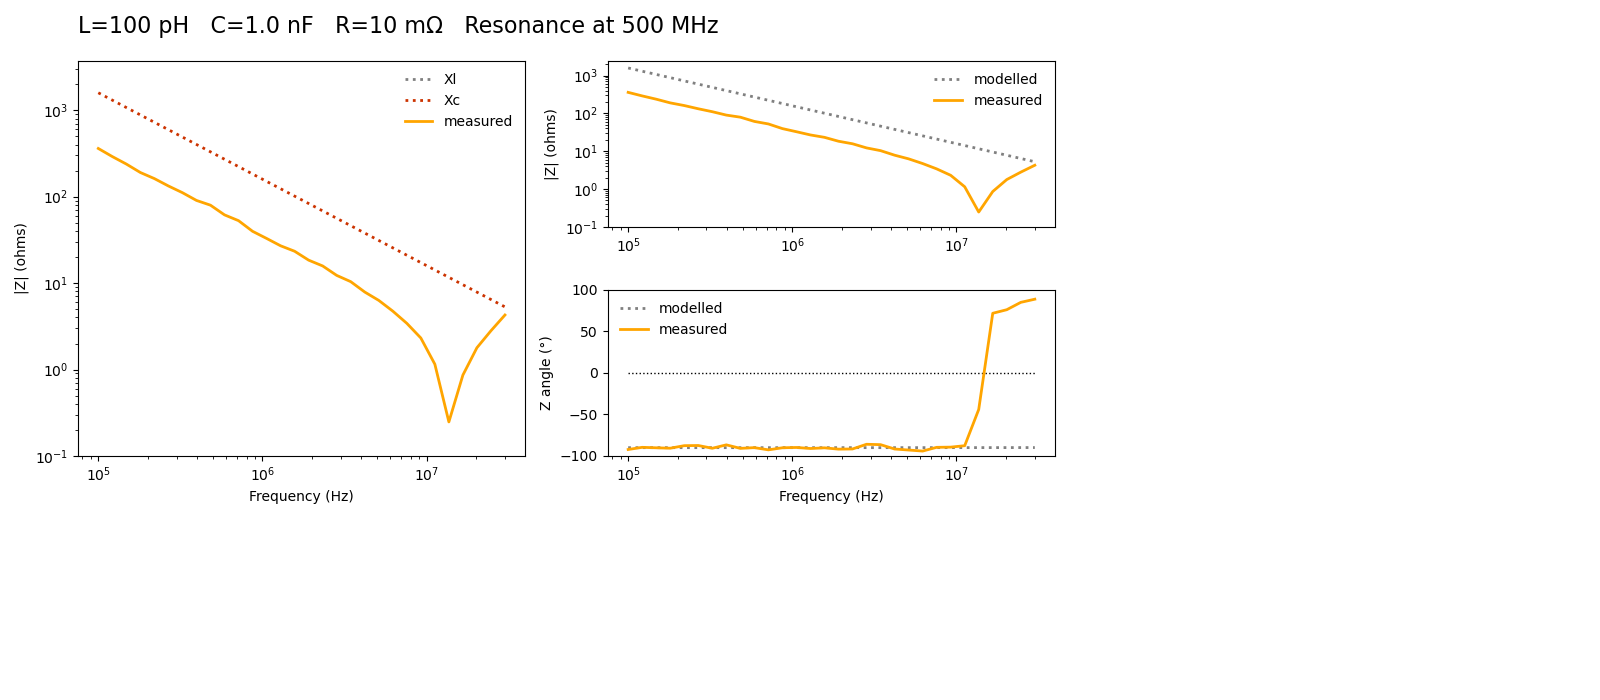

In [34]:
# fit model with sliders
%matplotlib ipympl
from scipy.optimize import fsolve
import mpl_interactions.ipyplot as iplt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import EngFormatter
from matplotlib import style

style.use('default')


def model_Xc_mag(F,L,C,R):
    Xl, Xc, Z = model(F,L,C,R)
    return np.abs(Xc)

def model_Xl_mag(F,L,C,R):
    Xl, Xc, Z = model(F,L,C,R)
    return np.abs(Xl)

def model_Z_angle(F,L,C,R):
    Xl, Xc, Z = model(F,L,C,R)
    return np.angle(Z,deg=True)

def model_Z_mag(F,L,C,R):
    Xl, Xc, Z = model(F,L,C,R)
    return np.abs(Z)

def result(L,C,R):
    Fr = 1./(2.*np.pi*np.sqrt(L*C))
    return 'L='+engineering_format(L,'H',significant_figures=significant_figures) +'   '+ \
           'C='+engineering_format(C,'F',significant_figures=significant_figures) +'   '+ \
           'R='+engineering_format(R,'\u03A9',significant_figures=significant_figures) +'   '+ \
           'Resonance at '+engineering_format(Fr,'Hz',significant_figures=significant_figures)


F = np.geomspace(start_frequency,end_frequency, num=number_of_points)
plt.close()
fig = plt.figure(num=' ',figsize=(16, 7))

ax1 = plt.subplot2grid(shape=(3, 3), loc=(0, 0), rowspan=2)
ax2 = plt.subplot2grid(shape=(3, 3), loc=(0, 1), colspan=1)
ax3 = plt.subplot2grid(shape=(3, 3), loc=(1, 1), colspan=1)

Rs = np.geomspace(nominal_R*10e-2,nominal_R*10e2,100000)
Cs = np.geomspace(nominal_C*10e-2,nominal_C*10e2,100000)
Ls = np.geomspace(nominal_L*10e-2,nominal_L*10e2,100000)

if model_type == 'parallel':
    controls = iplt.plot(F, model_Xl_mag, L=Ls, C=Cs, R=Rs, label='Xl', ylim='auto',
                         slider_formats={'L': '{:.2e}','C': '{:.2e}','R': '{:.2e}'}, ax=ax1, lw=2, ls=':',c='grey')
else:
    controls = iplt.plot(F, model_Xl_mag, C=Cs, L=Ls, R=Rs, label='Xl', ylim='auto',
                         slider_formats={'L': '{:.2e}','C': '{:.2e}','R': '{:.2e}'}, ax=ax1, lw=2, ls=':',c='grey')
    
    
iplt.plot(F, model_Xc_mag, label='Xc', ax=ax1, controls=controls, lw=2, ls=':',c='#CC3300')
ax1.plot(F,np.abs(Z_array),lw=2,c='orange',label='measured')
ax1.set_xscale("log")
ax1.set_yscale("log");
ax1.set_ylim(.1,None)
ax1.set_ylabel('|Z| (ohms)')
ax1.set_xlabel('Frequency (Hz)')
plt.legend(frameon=False)

with controls['L','C','R']:
    iplt.title(result,size=16,loc='left',pad=20)

iplt.plot(F, model_Z_mag, ax=ax2, controls=controls, lw=2, ls=':',c='grey',label='modelled')
ax2.plot(F,np.abs(Z_array),lw=2,c='orange',label='measured')
ax2.set_xscale("log")
ax2.set_yscale("log");
ax2.set_ylabel('|Z| (ohms)')
ax2.set_ylim(0.1,None)


plt.legend(frameon=False)

ax3.plot([F[0],F[-1]],[0,0],c='black',ls=':',lw=1)
iplt.plot(F, model_Z_angle, ax=ax3, controls=controls, lw=2, ls=':',c='grey',label='modelled')
ax3.plot(F,np.angle(Z_array,deg=True),lw=2,c='orange',label='measured')
ax3.set_xscale("log")
ax3.set_ylabel('Z angle (°)')
ax3.set_xlabel('Frequency (Hz)')


ax3.set_ylim(-100,100)
plt.legend(frameon=False)
fig.tight_layout()
plt.show()